# Test RD analysis with known references

## RD-Analyzer method - check for regions of difference presence with read alignments

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-3213-1

https://github.com/xiaeryu/RD-Analyzer

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
sys.path.append('pathogenie')
from pathogenie import tools,app,aligners,rd_analysis

In [2]:
path = '/storage/btbgenie/rd_test_data/'
meta = pd.read_csv(os.path.join(path, 'meta_data.csv'))
files = glob.glob(os.path.join(path, '*.gz'))
df = app.get_samples(files)

In [3]:
reload(rd_analysis)
rd_analysis.create_rd_index()

bwa index RD.fa


In [4]:
res = rd_analysis.find_regions(df,'../rd_test')

152.8388568869046
164.89220751430568
59.38063013030394
200.13075231008185
42.323916498848924
bwa mem -M -t 4 RD.fa /storage/btbgenie/rd_test_data/ERR551704_1.fastq.gz /storage/btbgenie/rd_test_data/ERR551704_2.fastq.gz | samtools view -F 0x04 -bt - | samtools sort -o ../rd_test/ERR551704.bam
25.2487693617546


In [5]:
res[res['#rname']=='RD2bcg']

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,name,ratio
5,RD2bcg,1,10700,7751,10698,99.98130,73.26080,29.5,0.0,ERR027294,0.479334
5,RD2bcg,1,10700,361,692,6.46729,1.22636,31.5,0.0,ERR234151,0.007437
5,RD2bcg,1,10700,2896,6168,57.64490,19.74780,36.1,0.0,ERR234238,0.332563
5,RD2bcg,1,10700,10102,10699,99.99070,92.05540,35.5,0.0,ERR234675,0.459976
5,RD2bcg,1,10700,1749,10660,99.62620,23.30730,35.2,0.0,ERR551023,0.550689
5,RD2bcg,1,10700,978,10591,98.98130,12.69970,35.3,0.0,ERR551704,0.502983


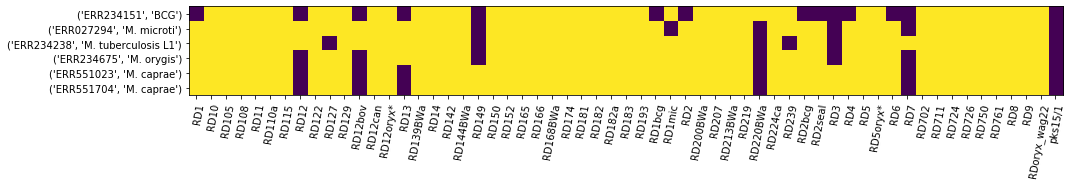

In [6]:
X = rd_analysis.get_matrix(res)
X=X.merge(meta[['ACCESSION','LINEAGE']],left_index=True,right_on='ACCESSION').set_index(['ACCESSION','LINEAGE'])
rd_analysis.plot_rd_matrix(X)
plt.savefig('RD_matrix_test.png',dpi=100)

In [19]:
X[['RD1','RD2bcg','RD3','RD4']]

,,RD1,RD2bcg,RD3,RD4
ACCESSION,LINEAGE,,,,
ERR027294,M. microti,0.0,0.0,0.0,1.0
ERR234151,BCG,0.0,0.0,0.0,0.0
ERR234238,M. tuberculosis L1,0.0,0.0,0.0,1.0
ERR234675,M. orygis,0.0,0.0,0.0,1.0
ERR551023,M. caprae,0.0,0.0,0.0,1.0


In [11]:
def apply_rules(x): 
    """Identify isolate using RD rules"""
    
    if x.RD239 == 0:
        return 'L1'
    elif x.RD105 == 0:
        return 'L2'
    elif x.RD4 == 1:
        if (x.RD1mic == 0):
            return 'Microti'
        elif (x.RD12bov == 0 or x.RD1bcg == 0 or x.RD2bcg == 0):
            return 'Caprae'
    elif x.RD4 == 0:
        if x.RD1bcg==1 and x.RD2bcg==1 and x.RD12bov == 0:
            return 'Bovis'
        elif x.RD1bcg==0 and x.RD2bcg==1:
            return 'BCG (Moreau)'
        elif x.RD1bcg==0 and x.RD2bcg==0:
            return 'BCG (Merieux)'
    elif x.RD711 == 0:
        return 'Africanum'

X.apply(apply_rules,1)

ACCESSION  LINEAGE           
ERR234151  BCG                   BCG (Merieux)
ERR027294  M. microti                  Microti
ERR234238  M. tuberculosis L1               L1
ERR234675  M. orygis                    Caprae
ERR551023  M. caprae                    Caprae
dtype: object

In [61]:
rules = pd.read_csv(os.path.join(rd_analysis.datadir,'RD_rules.csv'))
rules

,species,variant,rule,pks15/1,RD711,RD4,RD1bcg,RD1mic,RD2seal,RD2bcg,...,RD239,RD750,RD181,RD115,RD122,RD174,RD182,RD183,RD193,RD219
0,canetii,M. canetii,RD12can deletion AND no deletion of RD9 AND pks15/1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,africanum I,M. africanum I,RD711 deletion AND no deletion of RD1mic,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,africanum II,M. africanum II,RD711 deletion AND 6 bp deletion of pks15/1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,microti,M. microti,RD1mic deletion,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pinnipedii,M. pinnipedii,RD2seal deletion AND 6 bp deletion of pks15/1 AND (no deletion of RD711 OR RD2bcg),1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,caprae,M. caprae,RD12bov deletion AND 6 bp deletion of pks15/1 AND (no deletion of RD4 OR RD1bcg OR RD2bcg),1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,bovis,M. bovis (classical),RD4 deletion AND no deletion of RD1bcg AND RD2bcg,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,bcg,M. bovis BCG Moreau,RD4 AND RD1bcg deletion AND no deletion of RD2bcg,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,bcg,M. bovis BCG Merieux,RD4 AND RD1bcg AND RD2bcg deletion,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,mtb,Lineage 1,RD239 deletion,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
df

,name,sample,filename,pair
0,ERR027294_1,ERR027294,/storage/btbgenie/rd_test_data/ERR027294_1.fastq.gz,1
1,ERR027294_2,ERR027294,/storage/btbgenie/rd_test_data/ERR027294_2.fastq.gz,2
2,ERR234151_1,ERR234151,/storage/btbgenie/rd_test_data/ERR234151_1.fastq.gz,1
3,ERR234151_2,ERR234151,/storage/btbgenie/rd_test_data/ERR234151_2.fastq.gz,2
4,ERR234238_1,ERR234238,/storage/btbgenie/rd_test_data/ERR234238_1.fastq.gz,1
5,ERR234238_2,ERR234238,/storage/btbgenie/rd_test_data/ERR234238_2.fastq.gz,2
6,ERR234675_1,ERR234675,/storage/btbgenie/rd_test_data/ERR234675_1.fastq.gz,1
7,ERR234675_2,ERR234675,/storage/btbgenie/rd_test_data/ERR234675_2.fastq.gz,2
8,ERR551023_1,ERR551023,/storage/btbgenie/rd_test_data/ERR551023_1.fastq.gz,1
9,ERR551023_2,ERR551023,/storage/btbgenie/rd_test_data/ERR551023_2.fastq.gz,2
